# Анализ результатов А/В-теста

## Содержание

### [Обзор данных](#overview)

### [Предобработка данных](#processing)

* [Изменение типов данных](#type)
* [Анализ пропусков](#na)
* [Обработка регионов в таблице marketing_events](#m_events)
* [Объединение таблиц](#join)

### [Оценка корректности проведения А/В-теста](#check)

### [Исследовательский анализ данных](#eda)

### [Оценка результатов А/В-тестирования](#test)

### [Общий вывод и рекомендации](#summary)

---

**Цель проекта:** Провести оценку результатов А/В-теста.

**Задачи проекта:**
1. Оценить корректность проведения теста, а именно:
  * пересечение тестовой аудитории с конкурирующим тестом;
  * совпадение теста и маркетинговых событий, другие проблемы временных границ теста;
2. Проанализировать результаты теста.

**Техническое задание А/В-теста:**

* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000;
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
  * конверсии в просмотр карточек товаров — событие product_page;
  * просмотры корзины — product_cart;
  * покупки — purchase.

**План работы:**

1. Предобработка данных:

* первичный обзор данных;
* переименование колонок, если необходимо;
* поиск дубликатов, работа с ними;
* поиск пропусков, их удаление / заполнение;
* изменение типов данных, если необходимо;
* объединение таблиц.

2. Оценка корректности проведения теста:
* проверка соответствия данных требованиям технического задания по пунктам;
* анализ времени проведения теста, его совпадения с маркетинговыми и другими активностями;
* проверка отсутствия пересечений с конкурирующим тестом и отсутствия пользователей, участвующих в двух группах теста одновременно;
* анализ равномерности распределения пользователей по тестовым группам.

2. Исследовательский анализ данных:

  ответить на вопросы:
* количество событий на пользователя одинаково распределены в выборках?
* как число событий в выборках распределено по дням?
* как меняется конверсия в воронке в выборках на разных этапах?
* какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

3. Оценка результатов A/B-тестирования.

## Обзор данных
<a class='anchor' id='overview'></a>

In [1]:
# загружаем нужные библиотеки

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
import math as mth
from scipy import stats as st

In [2]:
# создаем функцию для загрузки данных

def download(path_1, path_2, path_3):

    if os.path.exists(path_1):
        data = pd.read_csv(path_1)
        print('Данные загружены в Colaboratory')

    elif os.path.exists(path_2):
        data = pd.read_csv(path_2)
        print('Данные загружены в Jupyter Notebook')

    elif os.path.exists(path_3):
        data = pd.read_csv(path_3)
        print('Данные загружены локально')

    else:
        print('Что-то пошло не так')

    return data

In [3]:
# создаем функцию для первичного обзора данных

def first_check(data):

    print('Первые 10 строк таблицы \n')
    display(data.head(10))

    print('-' * 50)
    print('Последние 10 строк таблицы \n')
    display(data.tail(10))

    print('-' * 50)
    print('Информация о таблице \n')   
    print(data.info())

    print('-' * 50)
    print('Характеристики чисел в таблице \n')  
    display(data.describe())

    print('-' * 50)
    print('Наименование колонок \n')  
    print(data.columns)

    print('-' * 50)
    print('Количество дубликатов:', data.duplicated().sum())

In [4]:
# загружаем календарь маркетинговых событий

marketing_events = download(
    'ab_project_marketing_events.csv',
    '/datasets/ab_project_marketing_events.csv',
    r'C:\Users\WANTNEON\Downloads\ab_project_marketing_events.csv'
    )

Данные загружены в Colaboratory


In [5]:
# смотрим на данные и их характеристики

first_check(marketing_events)

Первые 10 строк таблицы 



,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


--------------------------------------------------
Последние 10 строк таблицы 



,name,regions,start_dt,finish_dt
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


--------------------------------------------------
Информация о таблице 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
--------------------------------------------------
Характеристики чисел в таблице 



,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


--------------------------------------------------
Наименование колонок 

Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object')
--------------------------------------------------
Количество дубликатов: 0


In [6]:
# загружаем данные о новых пользователях

new_users = download(
    'final_ab_new_users.csv',
    '/datasets/final_ab_new_users.csv',
    r'C:\Users\WANTNEON\Downloads\final_ab_new_users.csv'
    )

Данные загружены в Colaboratory


In [7]:
first_check(new_users)

Первые 10 строк таблицы 



,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


--------------------------------------------------
Последние 10 строк таблицы 



,user_id,first_date,region,device
61723,29513E5C2EA1ECA6,2020-12-20,EU,Android
61724,F91FC39DF3340B60,2020-12-20,EU,PC
61725,80A8502B7EE59BA7,2020-12-20,EU,PC
61726,87608838CB813D53,2020-12-20,EU,Android
61727,F4BEEB17FEF0D52A,2020-12-20,EU,PC
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone
61732,8F04273BB2860229,2020-12-20,EU,Android


--------------------------------------------------
Информация о таблице 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None
--------------------------------------------------
Характеристики чисел в таблице 



,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


--------------------------------------------------
Наименование колонок 

Index(['user_id', 'first_date', 'region', 'device'], dtype='object')
--------------------------------------------------
Количество дубликатов: 0


In [8]:
# загружаем данные о событиях новых пользователей

events = download(
    'final_ab_events.csv',
    '/datasets/final_ab_events.csv',
    r'C:\Users\WANTNEON\Downloads\final_ab_events.csv'
    )

Данные загружены в Colaboratory


In [9]:
first_check(events)

Первые 10 строк таблицы 



,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


--------------------------------------------------
Последние 10 строк таблицы 



,user_id,event_dt,event_name,details
440307,1455450835F72F5E,2020-12-30 09:27:10,login,NaN
440308,339C4C55021A83C6,2020-12-30 12:55:08,login,NaN
440309,33E7BCF696B41C7B,2020-12-30 12:21:24,login,NaN
440310,D1553B56FFA8974B,2020-12-30 03:15:35,login,NaN
440311,6181F3835EBE66BF,2020-12-30 12:00:00,login,NaN
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
440316,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


--------------------------------------------------
Информация о таблице 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None
--------------------------------------------------
Характеристики чисел в таблице 



,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


--------------------------------------------------
Наименование колонок 

Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object')
--------------------------------------------------
Количество дубликатов: 0


In [10]:
# загружаем данные об участниках тестов

participants = download(
    'final_ab_participants.csv',
    '/datasets/final_ab_participants.csv',
    r'C:\Users\WANTNEON\Downloads\final_ab_participants.csv'
    )

Данные загружены в Colaboratory


In [11]:
first_check(participants)

Первые 10 строк таблицы 



,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
5,4FF2998A348C484F,A,recommender_system_test
6,7473E0943673C09E,A,recommender_system_test
7,C46FE336D240A054,A,recommender_system_test
8,92CB588012C10D3D,A,recommender_system_test
9,057AB296296C7FC0,B,recommender_system_test


--------------------------------------------------
Последние 10 строк таблицы 



,user_id,group,ab_test
18258,CE782A3646E8E5E1,A,interface_eu_test
18259,96304D5B53694096,A,interface_eu_test
18260,60A2B3B987457ECE,B,interface_eu_test
18261,A1281767A2983E4D,A,interface_eu_test
18262,4155D795096E6CFE,B,interface_eu_test
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test
18267,79F9ABFB029CF724,B,interface_eu_test


--------------------------------------------------
Информация о таблице 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None
--------------------------------------------------
Характеристики чисел в таблице 



,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


--------------------------------------------------
Наименование колонок 

Index(['user_id', 'group', 'ab_test'], dtype='object')
--------------------------------------------------
Количество дубликатов: 0


**Итоги обзора данных:**

* переименование колонок не требуется;

* в колонке details таблицы events есть пропуски, что может быть связано со значением колонки event_name;

* дубликаты отсутствуют во всех таблицах;

* необходимо поменять тип данных колонок с датами с object на datetime;

* в таблице marketing_events регионы записаны в одной колонке через запятую, следует их разделить по колонкам;

* максимальная стоимость покупки - 499.99 долларов, когда 75% не превышают стоимость в 9.99 долларов;

* новые пользователи пришли из 4 регионов, используют 4 девайса для входа;

* параллельно проводилось 2 А/В-теста.

## Предоработка данных
<a class='anchor' id='processing'></a>

### Изменение типов данных
<a class='anchor' id='type'></a>

Меняем тип данных колонок с датами.

In [12]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

new_users['first_date'] = pd.to_datetime(new_users['first_date'])

events['event_dt'] = pd.to_datetime(events['event_dt'])

### Анализ пропусков
<a class='anchor' id='na'></a>

In [13]:
# посмотрим на уникальные значения колонки event_name таблицы events

events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Проверим предположение о том, что пропуски в колонке details связаны со значением колонки event_name.

In [14]:
print('Всего строк в таблице events:', len(events))
print('Количество строк с пропусками в колонке details:',
      events['details'].isna().sum())
print('Количество строк со значениями кроме purchase в колонке event_name:',
      len(events.query('event_name != "purchase"')))

Всего строк в таблице events: 440317
Количество строк с пропусками в колонке details: 377577
Количество строк со значениями кроме purchase в колонке event_name: 377577


Предположение подтвердилось: заполненные значения - это стоимость покупок, а в остальных местах - пропуски. В таком случае пока что пропуски заполнять не будем, потому что они не случайны.

### Обработка регионов в таблице marketing_events
<a class='anchor' id='m_events'></a>

In [15]:
# извлечем колонку с регионами, разобъем ее значения на регионы,
# каждому присвоим номер индекса, который был в таблице

reg = (
    marketing_events.pop('regions')
    .str.split(r'\, ', expand=True)
    .stack()
    .reset_index(1, drop=True)
    .rename('region')
)

# добавляем полученный результат в таблицу, что продублирует строки с праздниками,
# но с разным регионами

marketing_events = marketing_events.join(reg).reset_index(drop=True)

### Объединение таблиц
<a class='anchor' id='join'></a>



Перед объединением посмотрим на максимальные и минимальные даты датасетов.

In [16]:
new_users['first_date'].agg(['max', 'min'])

max   2020-12-23
min   2020-12-07
Name: first_date, dtype: datetime64[ns]

In [17]:
marketing_events['finish_dt'].agg(['max', 'min'])

max   2021-01-07
min   2020-02-07
Name: finish_dt, dtype: datetime64[ns]

In [18]:
events['event_dt'].agg(['max', 'min'])

max   2020-12-30 23:36:33
min   2020-12-07 00:00:33
Name: event_dt, dtype: datetime64[ns]

Даты совпадают с документацией, кроме максимальной даты событий: в документации указано - 04.01.2021, а по факту - 30.12.2020. Сразу можно сказать, что это может привести к тому, что не у всех привлеченных пользователей можно посмотреть события на протяжении 14 дней, которые указаны в техническом задании к тесту.

Теперь посмотрим на количество уникальных пользователей в датасетах.

In [19]:
print(
    'Количество уникальных пользователей\nв new_users: {}\nв events: {}\nв participants: {}'
    .format(
        new_users['user_id'].nunique(),
        events['user_id'].nunique(),
        participants['user_id'].nunique()
        )
    )

Количество уникальных пользователей
в new_users: 61733
в events: 58703
в participants: 16666


Сразу можно отметить, что есть пользователи, которые участвовали в двух тестах или попали в две группы одного теста, поскольку в participants 18268 строк, что меньше количества уникальных пользователей.

Объединить таблицы необходимо таким образом, чтобы остались те новые пользователи, которые участвовали в тестах, поскольку новых пользователей пришло намного больше. 

In [20]:
# создаем таблицу с необходимыми для периода исследования праздниками

m_events = marketing_events.query(
    '"2020-12-07" <= start_dt <= "2021-01-04" | "2020-12-07" <= finish_dt <= "2021-01-04"'
    )

m_events

,name,start_dt,finish_dt,region
0,Christmas&New Year Promo,2020-12-25,2021-01-03,EU
1,Christmas&New Year Promo,2020-12-25,2021-01-03,N.America
25,CIS New Year Gift Lottery,2020-12-30,2021-01-07,CIS


Поскольку осталось три разных региона, то можно их присоединить к общей таблице, а затем обработать уже внутри.

In [21]:
# объединяем таблицы

data = (
    participants.merge(
        new_users,
        how='left',
        left_on='user_id',
        right_on='user_id')
    .merge(
        events,
        how='left',
        left_on='user_id',
        right_on='user_id')
    .merge(
        m_events,
        how='left',
        left_on='region',
        right_on='region')       
)

In [22]:
# оставляем названия праздников только там, где события попали в период праздника

data['name'] = np.where(
    (
        (data['start_dt'] <= data['event_dt']) &
     (data['finish_dt'] >= data['event_dt'])
    ),
    data['name'],
    'not holiday'
)

In [23]:
# удаляем лишние столбцы и переименовываем колонки
data = (
    data.drop(columns=['start_dt', 'finish_dt'])
    .rename(columns={'name' : 'side_event'})
)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110368 entries, 0 to 110367
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     110368 non-null  object        
 1   group       110368 non-null  object        
 2   ab_test     110368 non-null  object        
 3   first_date  110368 non-null  datetime64[ns]
 4   region      110368 non-null  object        
 5   device      110368 non-null  object        
 6   event_dt    106625 non-null  datetime64[ns]
 7   event_name  106625 non-null  object        
 8   details     15416 non-null   float64       
 9   side_event  110368 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 9.3+ MB


Поскольку в новом датасете есть пропуски, связанные с событиями, то есть пользователи, которые пришли на сайт, но не залогинились.

**Итоги предобработки данных:**

* Вероятнее всего, не у всех привлеченных пользователей можно посмотреть события на протяжении 14 дней, которые указаны в ТЗ к тесту, поскольку в датасете присутсвуют события до 30.12.2020, а не до 04.01.2021, как требовалось (либо тест остановили раньше, либо выгрузили не все данные);

* В датасете есть пользователи, которые участвовали в двух тестах или попали в две группы одного теста, поскольку количество строк с участниками тестов больше количества уникальных пользователей в этой таблице.

## Оценка корректности проведения А/В-теста
<a class='anchor' id='check'></a>

Начнем с проверки пересечения пользователей в разных тестах, группах и сторонних мероприятиях.

In [25]:
# находим пользователей, которые попали в группу В второго теста

other_test_users = (
    data.query('ab_test != "recommender_system_test" & group == "B"')
    ['user_id'].unique()
)

# находим пользователей, которые попали в оба теста
two_tests_users = data.query(
    'ab_test == "recommender_system_test" & user_id in @other_test_users'
    )['user_id'].unique()

In [26]:
print(
    'Общее количество пользователей, участвовавших в тестах: {}'
    .format(data['user_id'].nunique())
    )

print(
    'Количество пользователей, участвовавших в тесте recommender_system_test: {}'
    .format(data.query('ab_test == "recommender_system_test"')['user_id']
            .nunique())
    )

print(
    'Количество пользователей, участвовавших в двух тестах одновременно: {}'
    .format(len(two_tests_users))
    )

print(
    'Регион пользователей, участвовавших в двух тестах одновременно: {}'
    .format(
        data.query('user_id in @two_tests_users')
        ['region']
        .unique()
        )
)

print(
    'Процент пользователей из Европы, участвовавших в тесте recommender_system_test, от общего количества новых пользователей: {}'
    .format(round(
        data
        .query('ab_test == "recommender_system_test" & region == "EU"')
        ['user_id'].nunique()
        / new_users['user_id'].nunique() * 100, 2
        )
    )
    )

print(
    'Количество пользователей, участвовавших в стороннем мероприятии: {}'
    .format(
        data.query('side_event != "not holiday"')
        ['user_id']
        .nunique()
        )
    )

print(
    'Количество пользователей, участвовавших в двух тестах и стороннем мероприятии одновременно: {}'
    .format(
        data.query('user_id in @two_tests_users & side_event != "not holiday"')
        ['user_id']
        .nunique()
        )
    )

Общее количество пользователей, участвовавших в тестах: 16666
Количество пользователей, участвовавших в тесте recommender_system_test: 6701
Количество пользователей, участвовавших в двух тестах одновременно: 783
Регион пользователей, участвовавших в двух тестах одновременно: ['EU']
Процент пользователей из Европы, участвовавших в тесте recommender_system_test, от общего количества новых пользователей: 10.29
Количество пользователей, участвовавших в стороннем мероприятии: 4973
Количество пользователей, участвовавших в двух тестах и стороннем мероприятии одновременно: 144


Согласно ТЗ количество участников теста recommender_system_test должно составить 6000. Согласно данным в тесте участвовал 6701 пользователь, но 783 из них участвовало одновременно и в другом тесте. Если мы их удалим, то оставшееся число пользователей не будет соответствовать ТЗ. Также их удаление сократит процент пользователей из Европы, которое и так не соответствует 15%, указанных в ТЗ (возможно, не был учтем трафик из этого региона при расчете размера выборки для теста).

Посмотрим на распределение пользователей и их характеристик между группами теста.

In [27]:
# проверяем, нет ли пользователей, попавших в обе группы

len(
    data.query('ab_test == "recommender_system_test"')
    .groupby(['user_id'])
    .agg({'group' : 'nunique'})
    .query('group == 2')
)

0

In [28]:
# создаем датасет с данными теста

data_test = data.query('ab_test == "recommender_system_test"').copy()

In [29]:
# создаем функцию для анализа характеристик пользователей из группы теста
def group(group, data=data_test):

# создаем срез данных
        df = data.query('group == @group')

# группируем данные пользователей по регионам
        df_region = (
            df.groupby('region')
            .agg({'user_id' : 'nunique'})
            .sort_values(by='user_id')
        )

        df_region['percent'] = round(
            df_region['user_id'] / df_region['user_id'].sum() * 100, 2
        )

# группируем данные пользователей по девайсам
        df_device = (
            df.groupby('device')
            .agg({'user_id' : 'nunique'})
            .sort_values(by='user_id')
        )

        df_device['percent'] = round(
            df_device['user_id'] / df_device['user_id'].sum() * 100, 2
        )

# выводим необходимые данные
        print(
            'Количество пользователей в группе {}: {}'
            .format(group, df['user_id'].nunique())
            )
        
        print(
            'Количество пользователей, участвовавших в двух тестах одновременно в группе {}: {}'
            .format(
                group,
                df.query('user_id in @two_tests_users')['user_id'].nunique()
                )
            )
            
        print(
            'Процент пользователей, участвовавших в двух тестах одновременно в группе {}: {}'
            .format(
                group,
                round(
                    df.query('user_id in @two_tests_users')['user_id'].nunique()
                    / df['user_id'].nunique() * 100, 2
                    )
                )
            )
        
        print(
            'Процент пользователей, участвовавших в стороннем мероприятии, в группе {}: {}'
            .format(group, round(
                df.query('side_event != "not holiday"')['user_id'].nunique()
                / df['user_id'].nunique() * 100, 2))
        )        

        print(
            'Процент пользователей, участвовавших в двух тестах и стороннем мероприятии одновременно в группе {}: {}'
            .format(
                group,
                round(
                    df
                    .query('user_id in @two_tests_users & side_event != "not holiday"')
                    ['user_id']
                    .nunique()
                    / df['user_id'].nunique() * 100, 2
                    )
                )
            )
        
        print(
            'Процент пользователей, не совершивших ни одного события в группе {}: {}'
            .format(group, round(
                len(
                df.groupby('user_id')
                .agg({'event_dt' : 'count'})
                .query('event_dt == 0')
                ) / df['user_id'].nunique() * 100, 2))
        )

# выводим сгруппированные таблицы        
        print()
        print(
            'Количество пользователей из разных регионов в группе {}:'
            .format(group)
        )

        display(df_region)

        print()
        print(
            'Количество пользователей с разными девайсами в группе {}:'
            .format(group)
        )

        display(df_device)

        print()

        print('-' * 50)

In [30]:
# создаем функцию для визуализации распределений

def plot(df=data_test, first_dt=False):
    
    if first_dt == False:

        plt.figure(figsize=(20, 16))

# распределение событий по дате
        ax1 = plt.subplot(3, 2, 1)
        sns.histplot(
            data=df.loc[df['group'] == 'A', 'event_dt'],
            bins=23,
            color='ForestGreen')
        plt.title('Распределение данных по времени и дате события группы А')
        plt.xlabel('Дата события')
        plt.ylabel('Количество событий')

        ax2 = plt.subplot(3, 2, 2, sharey=ax1)
        sns.histplot(
            data=df.loc[df['group'] == 'B', 'event_dt'],
            bins=23,
            color='ForestGreen')
        plt.title('Распределение данных по времени и дате события группы B')
        plt.xlabel('Дата события')
        plt.ylabel('Количество событий')

# распределение пользователей по дате первого входа
        ax3 = plt.subplot(3, 2, 3)
        sns.histplot(
                data=(
                    df.loc[df['group'] == 'A']
                    .groupby('user_id')
                    .agg({'first_date' : 'first'})
                    ['first_date']
                ),
                bins=14,
                color='LimeGreen'
                )
        plt.title('Распределение пользователей по первому входу группы A')
        plt.xlabel('Дата первого входа')
        plt.ylabel('Количество пользователей')

        ax4 = plt.subplot(3, 2, 4, sharey=ax3)
        sns.histplot(
                data=(
                    df.loc[df['group'] == 'B']
                    .groupby('user_id')
                    .agg({'first_date' : 'first'})
                    ['first_date']
                ),
                bins=14,
                color='LimeGreen'
                )
        plt.title('Распределение пользователей по первому входу группы B')
        plt.xlabel('Дата первого входа')
        plt.ylabel('Количество пользователей')

# распределение пользователей по количеству событий
        ax5 = plt.subplot(3, 2, 5)
        sns.histplot(
                data=(
                    df.loc[df['group'] == 'A']
                    .groupby('user_id')
                    .agg({'event_dt' : 'count'})
                    ['event_dt']
                ),
                bins=25,
                color='GreenYellow'
                )
        plt.title('Распределение пользователей по количеству событий группы A')
        plt.xlabel('Количество событий на пользователя')
        plt.ylabel('Количество пользователей')

        ax6 = plt.subplot(3, 2, 6, sharey=ax5)
        sns.histplot(
                data=(
                    df.loc[df['group'] == 'B']
                    .groupby('user_id')
                    .agg({'event_dt' : 'count'})
                    ['event_dt']
                ),
                bins=25,
                color='GreenYellow'
                )
        plt.title('Распределение пользователей по количеству событий группы B')
        plt.xlabel('Количество событий на пользователя')
        plt.ylabel('Количество пользователей')

        plt.show()

# выводим только график распределения пользователей по дате первого входа
    else:
          
        plt.figure(figsize=(20, 5))

        ax1 = plt.subplot(1, 2, 1)
        sns.histplot(
            data=(
                df.loc[df['group'] == 'A']
                .groupby('user_id')
                .agg({'first_date' : 'first'})
                ['first_date']
            ),
            bins=14,
            color='LimeGreen'
            )
        plt.title('Распределение пользователей по первому входу группы A')
        plt.xlabel('Дата первого входа')
        plt.ylabel('Количество пользователей')

        ax2 = plt.subplot(1, 2, 2, sharey=ax1)
        sns.histplot(
            data=(
                df.loc[df['group'] == 'B']
                .groupby('user_id')
                .agg({'first_date' : 'first'})
                ['first_date']
            ),
            bins=14,
            color='LimeGreen'
            )
        plt.title('Распределение пользователей по первому входу группы B')
        plt.xlabel('Дата первого входа')
        plt.ylabel('Количество пользователей')

        plt.show()            

In [31]:
# применяем функцию
for gr in data_test['group'].unique():
    group(group=gr)

Количество пользователей в группе A: 3824
Количество пользователей, участвовавших в двух тестах одновременно в группе A: 439
Процент пользователей, участвовавших в двух тестах одновременно в группе A: 11.48
Процент пользователей, участвовавших в стороннем мероприятии, в группе A: 25.92
Процент пользователей, участвовавших в двух тестах и стороннем мероприятии одновременно в группе A: 2.98
Процент пользователей, не совершивших ни одного события в группе A: 28.16

Количество пользователей из разных регионов в группе A:


,user_id,percent
region,,
CIS,25,0.65
APAC,37,0.97
N.America,128,3.35
EU,3634,95.03



Количество пользователей с разными девайсами в группе A:


,user_id,percent
device,,
Mac,373,9.75
iPhone,768,20.08
PC,1011,26.44
Android,1672,43.72



--------------------------------------------------
Количество пользователей в группе B: 2877
Количество пользователей, участвовавших в двух тестах одновременно в группе B: 344
Процент пользователей, участвовавших в двух тестах одновременно в группе B: 11.96
Процент пользователей, участвовавших в стороннем мероприятии, в группе B: 7.96
Процент пользователей, участвовавших в двух тестах и стороннем мероприятии одновременно в группе B: 1.04
Процент пользователей, не совершивших ни одного события в группе B: 67.74

Количество пользователей из разных регионов в группе B:


,user_id,percent
region,,
CIS,30,1.04
APAC,35,1.22
N.America,95,3.30
EU,2717,94.44



Количество пользователей с разными девайсами в группе B:


,user_id,percent
device,,
Mac,260,9.04
iPhone,610,21.20
PC,696,24.19
Android,1311,45.57



--------------------------------------------------


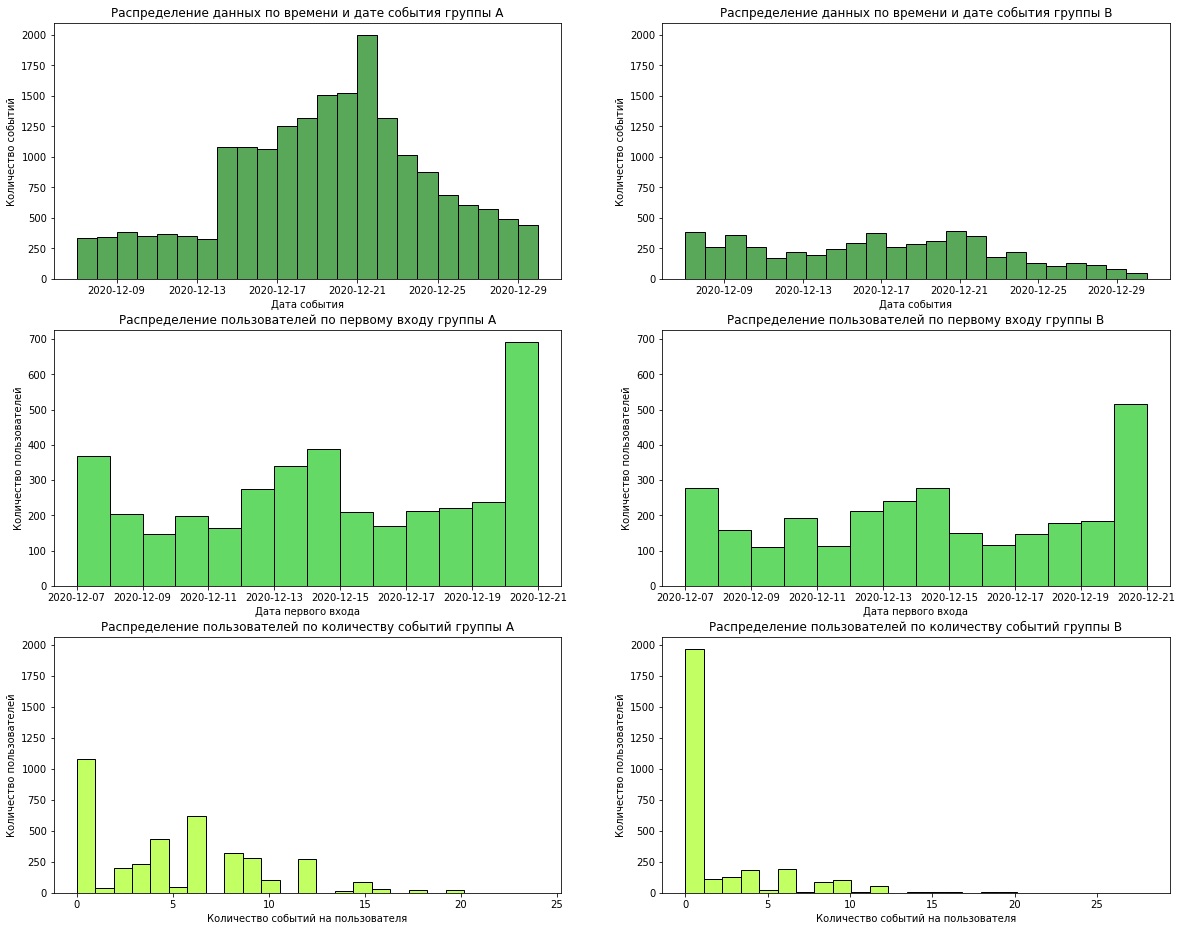

In [32]:
plot(df=data_test)

Проблемы с данными:
1. пользователи распределены не 50/50, а 57/43, в группу А на протяжении всего теста уходило больше пользователей.
2. в каждой группе есть по 11.5% - 12% пользователей, которые участвовали в другом тесте в группе В;
3. В группах ожидается нормальное распределение событий, однако 07-13.12.2020 в группе А количество событий держится на одном уровне, что не соответствует ожидаемому постепенному росту, а в группе В в этот период количество событий находится на уровне пика 21.12.2020 (в этот день закончился трафик новых пользователей);
4. Распределение пользователей по количеству событий в группах отличается. В группе В 67% пользователей не совершали каких либо событий, а в группе А таких - 28%.

---

Судя по распределению событий, маркетинговые кампании не повлияли на поведение новых пользователей. Никих скачков в эти даты не наблюдается. Таких пользователей удалять не стоит.

Данные по тесту имеются только до 30.12.2020, а не 04.01.2021, как требовалось в ТЗ, но пользователей, которые не имеют лайфтайм в 14 дней, требуемый в ТЗ, не стоит удалять. Это может компенсироваться, если пользователи проходят платежную воронку менее, чем за 14 дней, что проверим дальше.

Удалим пользователей, которые участвовали в обоих тестах. Они распределены по группам пропорционально, поэтому это не сильно исказит выборку. В таком случае в датасете останется 5918 пользователей, что не будет соблюдением пункта ТЗ о 6000 пользователей, участвовавших в тесте. Зато данные будут точнее.

Также посмотрим на пользователей, которые не совершили ни одного действия подробнее.

In [33]:
# удаляем пользователей, участвовавших в обоих тестах

data_test = data_test.query('user_id not in @two_tests_users').copy()

In [34]:
# находим пользователей, не совершивших ни одного действия

not_event_users = (
    data_test.groupby('user_id')
    .agg({'event_dt' : 'count'})
    .query('event_dt == 0')
)

# применяем функцию
for gr in data_test['group'].unique():
    group(group=gr,
          data=data_test.query('user_id in @not_event_users.index').copy())

Количество пользователей в группе A: 963
Количество пользователей, участвовавших в двух тестах одновременно в группе A: 0
Процент пользователей, участвовавших в двух тестах одновременно в группе A: 0.0
Процент пользователей, участвовавших в стороннем мероприятии, в группе A: 0.0
Процент пользователей, участвовавших в двух тестах и стороннем мероприятии одновременно в группе A: 0.0
Процент пользователей, не совершивших ни одного события в группе A: 100.0

Количество пользователей из разных регионов в группе A:


,user_id,percent
region,,
CIS,6,0.62
APAC,9,0.93
N.America,32,3.32
EU,916,95.12



Количество пользователей с разными девайсами в группе A:


,user_id,percent
device,,
Mac,88,9.14
iPhone,195,20.25
PC,253,26.27
Android,427,44.34



--------------------------------------------------
Количество пользователей в группе B: 1711
Количество пользователей, участвовавших в двух тестах одновременно в группе B: 0
Процент пользователей, участвовавших в двух тестах одновременно в группе B: 0.0
Процент пользователей, участвовавших в стороннем мероприятии, в группе B: 0.0
Процент пользователей, участвовавших в двух тестах и стороннем мероприятии одновременно в группе B: 0.0
Процент пользователей, не совершивших ни одного события в группе B: 100.0

Количество пользователей из разных регионов в группе B:


,user_id,percent
region,,
APAC,18,1.05
CIS,19,1.11
N.America,72,4.21
EU,1602,93.63



Количество пользователей с разными девайсами в группе B:


,user_id,percent
device,,
Mac,151,8.83
iPhone,363,21.22
PC,412,24.08
Android,785,45.88



--------------------------------------------------


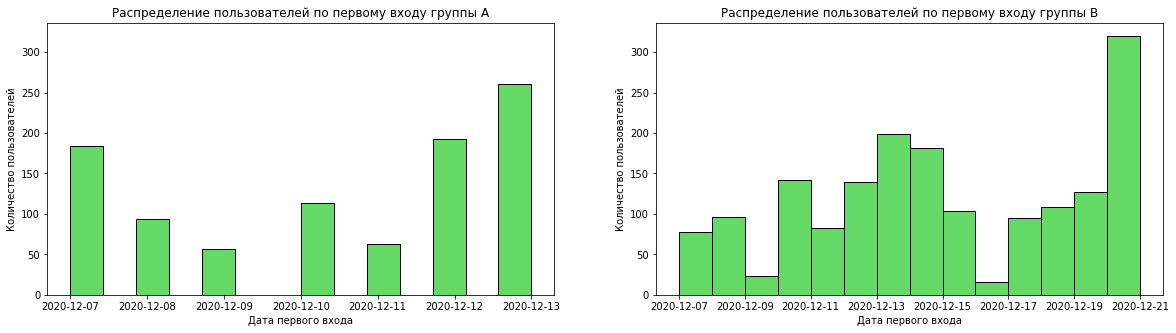

In [35]:
plot(df=data_test.query('user_id in @not_event_users.index').copy(),
     first_dt=True)

Пользователи, не совершившие ни одного действия одинаково распределены по регионам и девайсам в обеих группах. При этом такие пользователи в контрольной группе попадались примерно через день и только 07-13.12.2020, а в группе В такие пользователи есть на протяжении всех двух недель трафика. Это мог быть какой-то технический сбой, потому что процент таких пользователей в группах сильно отличается. 

Т.к. нет уверенности в происхождении таких пропусков, удалим пользователей без событий из датасета.

In [36]:
data_test = data_test.dropna(subset=['event_name'])

Применим функцию еще раз, чтобы посмотреть, с чем будем работать дальше.

In [37]:
# применяем функцию
for gr in data_test['group'].unique():
    group(group=gr, data=data_test)

Количество пользователей в группе A: 2422
Количество пользователей, участвовавших в двух тестах одновременно в группе A: 0
Процент пользователей, участвовавших в двух тестах одновременно в группе A: 0.0
Процент пользователей, участвовавших в стороннем мероприятии, в группе A: 36.21
Процент пользователей, участвовавших в двух тестах и стороннем мероприятии одновременно в группе A: 0.0
Процент пользователей, не совершивших ни одного события в группе A: 0.0

Количество пользователей из разных регионов в группе A:


,user_id,percent
region,,
CIS,19,0.78
APAC,28,1.16
N.America,96,3.96
EU,2279,94.10



Количество пользователей с разными девайсами в группе A:


,user_id,percent
device,,
Mac,226,9.33
iPhone,505,20.85
PC,630,26.01
Android,1061,43.81



--------------------------------------------------
Количество пользователей в группе B: 822
Количество пользователей, участвовавших в двух тестах одновременно в группе B: 0
Процент пользователей, участвовавших в двух тестах одновременно в группе B: 0.0
Процент пользователей, участвовавших в стороннем мероприятии, в группе B: 24.21
Процент пользователей, участвовавших в двух тестах и стороннем мероприятии одновременно в группе B: 0.0
Процент пользователей, не совершивших ни одного события в группе B: 0.0

Количество пользователей из разных регионов в группе B:


,user_id,percent
region,,
CIS,11,1.34
APAC,17,2.07
N.America,23,2.80
EU,771,93.80



Количество пользователей с разными девайсами в группе B:


,user_id,percent
device,,
Mac,69,8.39
iPhone,170,20.68
PC,200,24.33
Android,383,46.59



--------------------------------------------------


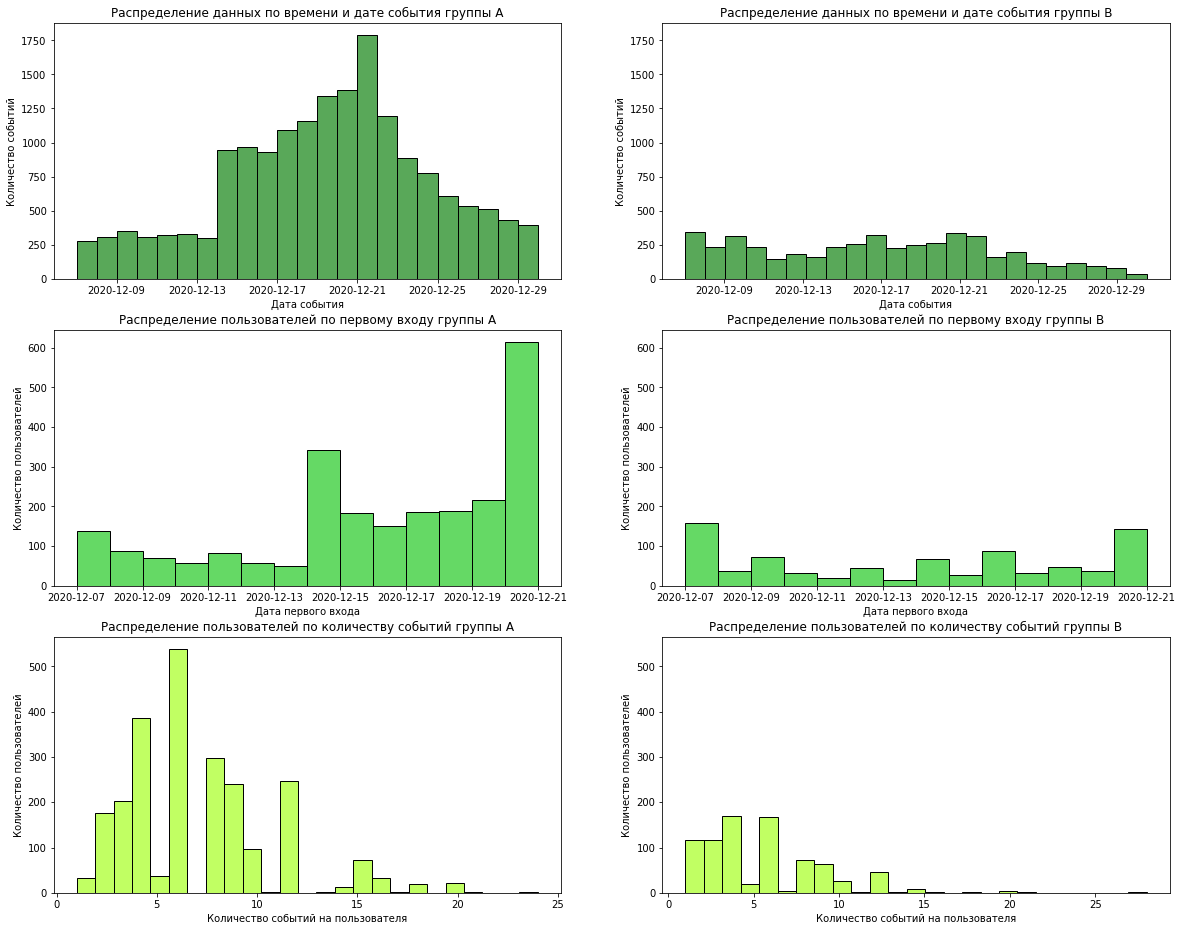

In [38]:
plot(df=data_test)

В распределении событий все так и осталось.

Распределение событий по первому входу и распределение количества событий на пользователя выглядят похоже, но группа В - уменьшенная копия группы А.

In [39]:
print(
    'Процент пользователей из Европы от общего количества новых пользователей: {}'
    .format(round(
        data_test.query('region == "EU"')['user_id'].nunique()
        / new_users['user_id'].nunique() * 100, 2
        )
    )
    )

Процент пользователей из Европы от общего количества новых пользователей: 4.94


**Итоги оценки корректности проведения А/В-теста:**

Данные теста соответствуют следующим пунктам ТЗ:
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;

Данные не соответствуют следующим пунктам ТЗ:
* Ожидаемое количество участников теста: 6000. По факту осталось 3244, 75% в группе А и 25% в группе В.
* Дата остановки: 2021-01-04. По факту имеются данные до 2020-12-30, из-за чего часть пользователей не имеют лайфтайм в 14 дней. Это может компенсироваться тем, что пользователи проходят платежную воронку за меньший период.
* Аудитория: 15% новых пользователей из региона EU. По факту - 5% новых пользователей из региона EU участвуют в тесте.

## Исследовательский анализ данных
<a class='anchor' id='eda'></a>

Не все пользователи имеют лайфтайм в 14 дней, минимальный лайфтайм - 9 дней. Выше было отмечено, что это будет компенсироваться, если пользователи совершают различные действия в первые дни лайфтайма.

Посмотрим, на какой день лайфтайма пользователи совершают различные действия в первый раз.

In [40]:
# добавляем к датасету колонку с днем лайфтайма, в который совершено событие
data_test['lifetime'] = (data_test['event_dt'] - data_test['first_date']).dt.days

In [41]:
# создаем функцию, которая выводит количество первых событий на день лайфтайма 

def event_count(event_name):
      result = (
          data_test.loc[data_test['event_name'] == event_name]
          .sort_values(by=['user_id', 'lifetime'])
          .groupby('user_id')
          .agg({'lifetime' : 'first'})
          ['lifetime'].value_counts()
          )
      return result

In [42]:
# применяем функцию для каждого типа события

for event in data_test['event_name'].unique():
    print(
        'Дни лайфтайма, в которые совершаются первые {}:\n{}\n'
        .format(event, event_count(event))
        )

Дни лайфтайма, в которые совершаются первые purchase:
0    993
1      5
6      1
Name: lifetime, dtype: int64

Дни лайфтайма, в которые совершаются первые product_cart:
0    948
2      2
1      2
6      1
Name: lifetime, dtype: int64

Дни лайфтайма, в которые совершаются первые product_page:
0    2018
1       7
2       2
6       1
8       1
3       1
Name: lifetime, dtype: int64

Дни лайфтайма, в которые совершаются первые login:
0     3222
1       10
2        4
6        2
3        2
4        1
8        1
5        1
18       1
Name: lifetime, dtype: int64



Почти все пользователи совершают события в день посещения сайта. Следовательно, продолжительность лайфтайма не так важна.

Посмотрим на распределение событий в датасете.

In [43]:
data_test['event_name'].value_counts()

login           9901
product_page    6116
purchase        2939
product_cart    2886
Name: event_name, dtype: int64

Поскольку просмотров корзины немного меньше, чем покупок, то можно сказать, что совершить покупку можно сразу на странице продукта, в корзину переходить необязательно.

Построим воронку для всех пользователей, участвовавших в тесте, и для каждой группы в отдельности.

In [44]:
# находим общее количество пользователей в группах
users_sum = data_test.pivot_table(
    columns='group',
    values='user_id',
    aggfunc='nunique'
)

# группируем данные по событиям для каждой группы

event_user = (
    data_test
    .pivot_table(
        index='event_name',
        columns='group',
        values='user_id',
        aggfunc='nunique'
        )
    .sort_values(by='A', ascending=False)
    .reindex(['login', 'product_page', 'product_cart', 'purchase'])
)

# добавляем колонку с общими значениеми для пользователей из обеих групп
event_user['common'] = event_user['A'] + event_user['B']

In [45]:
# строим общую воронку
fig = go.Figure(go.Funnel(
    name = 'Обе группы',
    y = event_user.index,
    x = event_user['common'],
    textinfo = 'value+percent initial',
    marker = {'color': 'DarkOliveGreen'}))

fig.show()

In [46]:
# строим воронку для групп

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = event_user.index,
    x = event_user['A'],
    textinfo = 'value+percent initial',
    marker = {'color': 'Olive'}))

fig.add_trace(go.Funnel(
    name = 'Группа В',
    y = event_user.index,
    x = event_user['B'],
    textinfo = 'value+percent initial',
    marker = {'color': 'YellowGreen'}))

fig.show()

Согласно ТЗ должны проверяться конверсии с момента регистрации в другое событие. Их и опишем.

* Конверсия из входа в карточку продукта у группы А составляет 65%, а у группы В - 56%.

* Конверсия из входа в оплату у группы А - 32%, у группы В - 27%.

* Конверсия из входа в корзину у группы А - 30%, у группы В - 27%.

**Итоги исследовательского анализа данных:**

В процессе оценки корректности проведеления теста было определено:

1. В период с 07-30.12.2020 большинство пользователей совершило до 12 событий. 22% пользователей из группы А совершило 6 событий, 16% - 4 события, а в группе В 4 и 6 событий совершило по 20.5% пользователей.

2. В группах ожидается нормальное распределение событий, однако 07-13.12.2020 в группе А количество событий держится на одном уровне, что не соответствует ожидаемому постепенному росту, а в группе В в этот период количество событий находится на уровне пика 21.12.2020 (в этот день закончился трафик новых пользователей). В период 13-30.12.2020 распределение в обеих группах похоже на нормальное с пиком 21.12.2020.

В процессе исследовательского анализа было определено, что конверсии тестовой группы показывают себя на 3-9 процентных пункта хуже, чем конверсии контрольной группы. Далее необходимо проверить статистическую значимость различий в указанных пропорциях. При этом необходимо учитывать, что выборка была уменьшена и пользователи распределены между группами 75% / 25%.

## Оценка результатов А/В-тестирования
<a class='anchor' id='test'></a>

Проверим статистическую значимость между группами, чтобы понять, является ли разница в конверсии контрольной и тестовой групп значительным отличием.

In [47]:
# создадим функцию, которая будет рассчитывать статистическую значимость
# различий в пропорциях при указанных размерах выборок

def events_stat(user_count, group_number_1, group_number_2, event_name,
                alpha, one_side=False):

    # определяем массив для выборок
    trials = np.array(
        [event_user.loc[user_count, group_number_1],
        event_user.loc[user_count, group_number_2]]
        )
    
    # определяем массив для событий
    successes = np.array(
        [event_user.loc[event_name, group_number_1],
        event_user.loc[event_name, group_number_2]]
        )

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1])
        )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    if one_side == True:
      p_value = (1 - distr.cdf(abs(z_value)))
    else:
      p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', round(p_value, 4))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

Чтобы найти баланс между мощностью и значимостью, применим критический уровень значимости равной 0.1 с поправкой на множественную проверку гипотез, поскольку выборки получились небольшими и из-за разных по размеру выборок мощность уменьшать опасно.

Проверяем гипотезы.

Н0: нет различий в конверсии из регистрации в просмотр карточки продукта.

Н1: есть различия в конверсии из регистрации в просмотр карточки продукта.

In [48]:
events_stat('login', 'A', 'B', 'product_page', alpha=0.1/3)

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Н0: нет различий в конверсии из регистрации в покупку.

Н1: есть различия в конверсии из регистрации в покупку.

In [49]:
events_stat('login', 'A', 'B', 'purchase', alpha=0.1/3)

p-значение:  0.0176
Отвергаем нулевую гипотезу: между долями есть значимая разница


Н0: нет различий в конверсии из регистрации в просмотр корзины.

Н1: есть различия в конверсии из регистрации в просмотр корзины.

In [50]:
events_stat('login', 'A', 'B', 'product_cart', alpha=0.1/3)

p-значение:  0.1441
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Итоги оценки результатов А/В-теста:**

Нулевые гипотезы о различии между контрольной группой и тестовой группой при переходе из регистрации к просмотру карточек продуктов и покупкам подтвердились, что говорит о том, что:

* различия между ними являются статистически значимыми,

* изменения рекомендательной системы влияют на поиск продукта и дальнейшую покупку в худшую сторону.

Нулевая гипотеза о различии между контрольной группой и тестовой группой при переходе из регистрации к просмотру корзины не подтвердилась, что говорит о том, что:

* различия между ними не являются статистически значимыми,

* изменения рекомендательной системы не влияют на просмотр пользователем корзины.

## Общий вывод и рекомендации
<a class='anchor' id='summary'></a>

1. Тест проведен некорректно, т.к.:
  * пользователи между группами не распределены 50/50;
  * часть пользователей участвовало в параллельном тестировании в тестовой группе;
  * есть вероятность технического сбоя, связанного с отсутствием записей о части пользователей после перехода на сайт;
  * дата окончания на 5 дней раньше указанной в ТЗ, из-за чего у части пользователей отсутсвует требуемый лайфтайм в 14 дней;
  * в тесте участвует меньший процент новых пользователей из Европы, чем указано в ТЗ;
  * после удаления части данных из-за вышеуказанных проблем, количество анализируемых пользователей сократилось вдвое и перестало соответсвовать требованию в 6000 участников.


2. Конверсия из входа в карточку продукта у группы А составляет 65%, у группы В - 56%. Разница между группами является статистически значимой, т.е. изменения рекомендательной системы уменьшают процент конверсии, а не улучшает ее, как ожидалось.


3. Конверсия из входа в оплату у группы А - 32%, у группы В - 27%. Разница между группами является статистически значимой, т.е. изменения рекомендательной не улучшают конверсию.


4. Конверсия из входа в корзину у группы А - 30%, у группы В - 27%. Разница между группами не является статистически значимой, т.е. изменения рекомендательной системы не сильно влияют на конверсию.

**Рекомендации:**

* Более тщательно проводить А/А-тест, следить за равномерным распределением пользователей между группами.
* Рассчитывать необходимое количество пользователей для теста с учетом трафика в соответствии с дополнительным критерием (например, пользователи из конкретного региона, с определенным девайсом и т.п.);
* Проверять, все ли действия пользователей записываются в системе.